In [20]:
#data preprocessing
import pandas as pd
import numpy as np
import spacy
import yfinance as yf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

#building model
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

#Performance Metrics
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Load csv file into dataframe
data = pd.read_csv("/content/GlassDoor_1000_Companies.csv")

# Replace 'k' with '000' in Reviews and Salaries columns
data['Reviews'] = data['Reviews'].str.replace('K', '000')
data['Salaries'] = data['Salaries'].str.replace('K', '000')
data['Jobs'] = data['Jobs'].str.replace('K', '000')


# Extract only the number from the Location column if plural, otherwise assume 1 location if single address
for i, row in enumerate(data['Location']):
    if 'office' in row:
        num = re.findall(r'\d+', row)[0]
        data.at[i, 'Location'] = num
    else:
        data.at[i, 'Location'] = 1

# Extract only the number from the Company_Size column if plural, otherwise assume lowest employee size
for i, row in enumerate(data['Company_Size']):
    if '+' in row:
        num = re.findall(r'\d+', row)[0]
        data.at[i, 'Company_Size'] = num
    elif 'to' in row:
        num = re.findall(r'\d+', row)[0]
        data.at[i, 'Company_Size'] = num
    else:
        # if the value is 'Unknown', drop the row
        data.drop(i, inplace=True)

#standardize industry names 
def standardize_industry(industry_name):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(industry_name)
    standardized_industry = ''
    for token in doc:
        if not token.is_stop and not token.is_punct:
            standardized_industry += token.lemma_ + ' '
    return standardized_industry.strip()

#find valuation of company
for i, company_name in enumerate(data['Company']):
    try:
        # Search for ticker symbol on Yahoo Finance
        ticker_symbol = yf.Ticker(company_name).info.get("symbol", "")
        # Get valuation from Yahoo Finance
        valuation = yf.Ticker(company_name).info.get("marketCap", "")
        # Update the new column
        data.at[i, "Symbol"] = ticker_symbol
        data.at[i, "Valuation"] = valuation
    except:
        data.at[i, 'Symbol'] = 'private'
        data.at[i, 'Valuation'] = 0

# Convert the Salaries, Reviews, Locations, Company_Size and Valuation columns to numeric format
data['Salaries'] = pd.to_numeric(data['Salaries'])
data['Reviews'] = pd.to_numeric(data['Reviews'])
data['Location'] = pd.to_numeric(data['Location'])
data['Company_Size'] = pd.to_numeric(data['Company_Size'])
data['Valuation'] = pd.to_numeric(data['Valuation'])
data['Jobs'] = pd.to_numeric(data['Jobs'])


# remove bias
scaler = MinMaxScaler()
data[['Reviews', 'Location', 'Company_Size', 'Valuation', 'Salaries']] = scaler.fit_transform(data[['Reviews', 'Location', 'Company_Size', 'Valuation', 'Salaries']])

# Drop rows with missing or NaN values
data.dropna(inplace=True)

# Load target column
y = data['Salaries']

# Prepare training features, remove target and Location columns
X = data.drop(['Salaries', 'Company', 'Symbol'], axis=1)

# Partition into training and testing blocks
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train['Industry'] = X_train['Industry'].apply(standardize_industry)

#keep top 5 industries for simplicity with one-hot encoding
top_5_industries = X_train['Industry'].value_counts().nlargest(5).index
X_train.loc[~X_train['Industry'].isin(top_5_industries), 'Industry'] = 'Other'

# Convert 'Industry' column to categorical data type
X_train['Industry'] = X_train['Industry'].astype('category')

# Perform one hot encoding on 'Industry' column
X_train = pd.concat([X_train.drop('Industry', axis=1), pd.get_dummies(X_train['Industry'], prefix='Industry')], axis=1)

# Apply industry standardization to test variables
X_test['Industry'] = X_test['Industry'].apply(standardize_industry)
X_test.loc[~X_test['Industry'].isin(top_5_industries), 'Industry'] = 'Other'

# Convert 'Industry' column to categorical data type
X_test['Industry'] = X_test['Industry'].astype('category')

# Perform one hot encoding on 'Industry' column
X_test = pd.concat([X_test.drop('Industry', axis=1), pd.get_dummies(X_test['Industry'], prefix='Industry')], axis=1)


In [28]:
#////////////////////////////////////////////////////////////////////////////////
#////////////////////////////////////////////////////////////////////////////////
#////////////////////////// Neural Network //////////////////////////////////////
#////////////////////////////////////////////////////////////////////////////////
#////////////////////////////////////////////////////////////////////////////////
# Build the model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss=['mae', 'mse'], optimizer='adam')

# Define early stopping criteria
early_stop = EarlyStopping(monitor='val_loss', patience=15)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# Generate predictions on test data
y_pred = model.predict(X_test)

# Compute MAE and MSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("\nNEURAL NETWORK RESULTS: \n")
print("MAE:", mae, "\n")
print("MSE:", mse, "\n\n")

#////////////////////////////////////////////////////////////////////////////////
#////////////////////////////////////////////////////////////////////////////////
#///////////////////////////////// XGBoost //////////////////////////////////////
#////////////////////////////////////////////////////////////////////////////////
#////////////////////////////////////////////////////////////////////////////////

# Convert data to a DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# build model
num_rounds = 100
early_stop_rounds = 15
watchlist = [(dtrain, 'train'), (dtest, 'test')]
model = xgb.train(params, dtrain, num_rounds, evals=watchlist,
                  early_stopping_rounds=early_stop_rounds)

# Evaluate the model
test_preds = model.predict(dtest)
mae_loss = np.mean(np.abs(test_preds - y_test))
mse_loss = np.mean((test_preds - y_test)**2)
print("\nXGBoost MODEL RESULTS: \n")
print("MAE:", mae_loss)
print("MSE:", mse_loss)

#////////////////////////////////////////////////////////////////////////////////
#////////////////////////////////////////////////////////////////////////////////
#//////////////////////////  Random Forest //////////////////////////////////////
#////////////////////////////////////////////////////////////////////////////////
#////////////////////////////////////////////////////////////////////////////////

# build model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("\nRANDOM FOREST RESULTS: \n")
print("MAE:", mae)
print("MSE:", mse)


Epoch 1/50
19/19 [==============================] - 2s 14ms/step - loss: 0.4652 - val_loss: 0.2845
Epoch 2/50
19/19 [==============================] - 0s 5ms/step - loss: 0.2028 - val_loss: 0.1349
Epoch 3/50
19/19 [==============================] - 0s 6ms/step - loss: 0.1119 - val_loss: 0.0875
Epoch 4/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0778 - val_loss: 0.0673
Epoch 5/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0587 - val_loss: 0.0558
Epoch 6/50
19/19 [==============================] - 0s 6ms/step - loss: 0.0500 - val_loss: 0.0485
Epoch 7/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0439 - val_loss: 0.0430
Epoch 8/50
19/19 [==============================] - 0s 6ms/step - loss: 0.0372 - val_loss: 0.0392
Epoch 9/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0351 - val_loss: 0.0361
Epoch 10/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0307 - val_loss: 0.0338
Epoch 11/50
19/19 

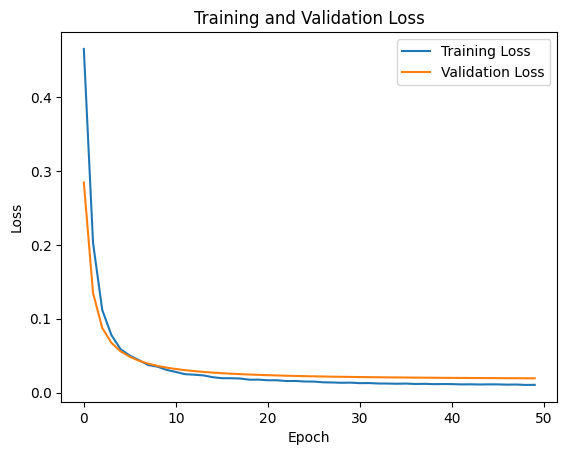

In [32]:
# Get training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
